In [1]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
# script specific imports
import os

In [3]:
mus_tfs = np.loadtxt('/camp/home/maizelr/working/Rory/transcriptomics/gene_lists/SCENIC/mm_mgi_tfs.txt', dtype=str)
hom_tfs = np.loadtxt('/camp/home/maizelr/working/Rory/transcriptomics/gene_lists/SCENIC/hs_hgnc_tfs.txt', dtype=str)
mus_ntg = np.load('/camp/home/maizelr/working/Rory/transcriptomics/gene_lists/list_of_genes', allow_pickle=True)
hom_ntg = pd.read_csv('/camp/home/maizelr/working/Rory/transcriptomics/gene_lists/hNT_genes.csv')['0'].values

In [4]:
delile_path = '/camp/home/maizelr/working/Rory/transcriptomics/mouse_transcriptomics_data/full_data/new_mouse_velocity_20210121.loom'
trayon_path = '/camp/home/maizelr/working/Rory/transcriptomics/human_transcriptomics_analysis/data/new_human_velocity_20210121.loom'

In [5]:
humannt = scv.read_loom(trayon_path)
mousent = scv.read_loom(delile_path)
mousent.var = mousent.var.set_index('var_names')
humannt.var = humannt.var.set_index('var_names')
bonemar = scv.datasets.bonemarrow()
dentate = scv.datasets.dentategyrus()
lamanno = scv.datasets.dentategyrus_lamanno()
pncreas = scv.datasets.pancreas()

  0%|          | 0.00/162M [00:00<?, ?B/s]

  0%|          | 0.00/23.7M [00:00<?, ?B/s]

  0%|          | 0.00/249M [00:00<?, ?B/s]

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

In [6]:
os.system("rm -r data")
os.system("rm -r cache")
print("all done.")

all done.


In [20]:
datas = [bonemar,dentate,lamanno,pncreas,humannt,mousent]
xs = []
for x in datas:
    x = (x.layers['spliced'] + x.layers['unspliced']).A
    xs.append(np.mean(x[x>0], axis=0))
np.mean(xs)

2.412076865934458

In [13]:
datas = [bonemar,dentate,lamanno,pncreas,humannt,mousent]
names = ['Human\nBone\nMarrow', 'Mouse\nDentate\nGyrus 1', 'Mouse\nDentate\nGyrus 2', 'Mouse\nPancreas', 'Human\nNeural\nTube', 'Mouse\nNeural\nTube']
for data in datas:
    if np.mean([a==a.upper() for a in data.var_names[:10000]])>.9: #>0.9 not ==1 because some mistake gene names occur
        data.species = 'human'
    else:
        data.species = 'mouse'
        
all_genes_below5 = []
for adata in tqdm(datas):
    uns = adata.layers['unspliced'].A if issparse(adata.layers['unspliced']) else adata.layers['unspliced']
    spl = adata.layers['spliced'].A if issparse(adata.layers['spliced']) else adata.layers['spliced']
    tot = uns+spl

    genewise_splicing = uns.sum(0) / tot.sum(0)
    
    all_genes_below5.append(100*np.mean(genewise_splicing<=0.05))
    
tfs_below5 = []
for adata in tqdm(datas):
    if adata.species=='human':
        gene_list=hom_tfs
    elif adata.species=='mouse':
        gene_list=mus_tfs
    genes = list(set(gene_list).intersection(adata.var_names))

    sub = adata[:,genes]

    uns = sub.layers['unspliced'].A if issparse(sub.layers['unspliced']) else sub.layers['unspliced']
    spl = sub.layers['spliced'].A if issparse(sub.layers['spliced']) else sub.layers['spliced']
    tot = uns+spl

    genewise_splicing = uns.sum(0) / tot.sum(0)
    
    tfs_below5.append(100*np.mean(genewise_splicing<=0.05))
    
nt_below5 = []
for dat, gen in zip([mousent, humannt], [mus_ntg,hom_ntg]):
    genes = list(set(gen).intersection(dat.var_names))

    sub = dat[:,genes]

    uns = sub.layers['unspliced'].A if issparse(sub.layers['unspliced']) else sub.layers['unspliced']
    spl = sub.layers['spliced'].A if issparse(sub.layers['spliced']) else sub.layers['spliced']
    tot = uns+spl

    genewise_splicing = uns.sum(0) / tot.sum(0)
    
    nt_below5.append(100*np.mean(genewise_splicing<=0.05))
    
hvg_below5 = []
for adata in tqdm(datas):
    copy = adata.copy()
    sc.pp.normalize_total(copy, target_sum=1e4)
    sc.pp.log1p(copy)
    sc.pp.highly_variable_genes(copy, n_top_genes=2000)
    genes = copy[:, copy.var.highly_variable].var_names
    
    sub = adata[:,genes]
    
    uns = sub.layers['unspliced'].A if issparse(sub.layers['unspliced']) else sub.layers['unspliced']
    spl = sub.layers['spliced'].A if issparse(sub.layers['spliced']) else sub.layers['spliced']
    tot = uns+spl

    genewise_splicing = uns.sum(0) / tot.sum(0)
    
    hvg_below5.append(100*np.mean(genewise_splicing<=0.05))
    
df = pd.DataFrame({"Proportion of genes with %unspliced < 5": all_genes_below5 + tfs_below5 + hvg_below5,
                   "Subset":["All Genes"]*6 + ["Transcription Factors"]*6 + ["Highly Variable Genes"]*6,
                   "Dataset":names+names+names})

100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


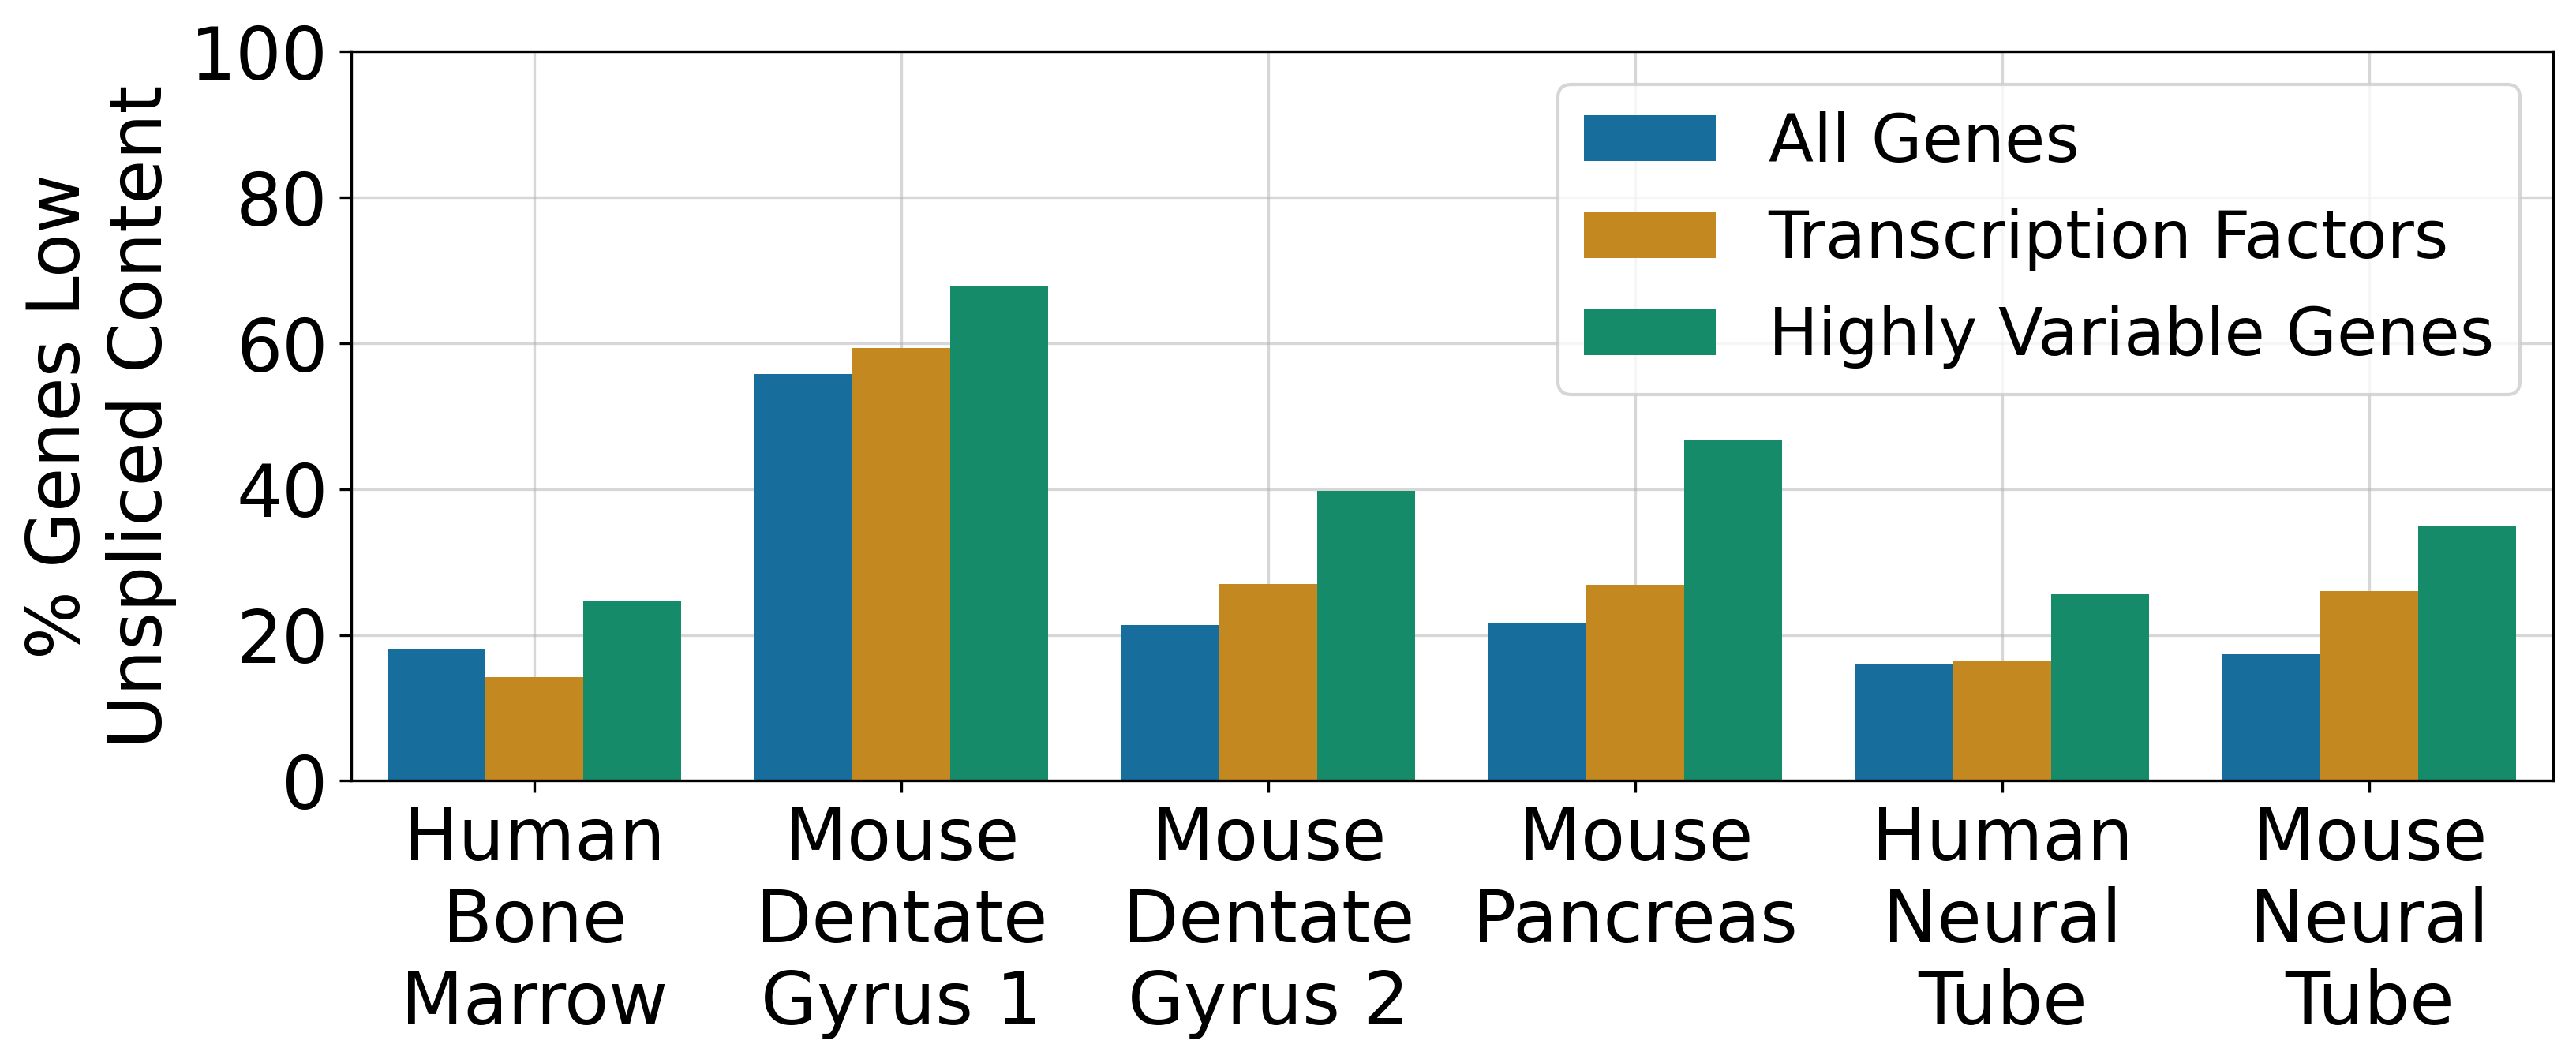

In [20]:
plt.figure(figsize=(12,4), dpi=300)
ax = sns.barplot(x='Dataset',y="Proportion of genes with %unspliced < 5",hue="Subset", data=df,palette=colpal.cmap_cat1, zorder=2)
plt.legend(fontsize=20)
plt.xticks(rotation=0, fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('', fontsize=22)
plt.ylabel("% Genes Low\nUnspliced Content", fontsize=22)
plt.ylim((0,100))

# Set grid
ax.grid(alpha=0.5, zorder=0) 

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    fig.patch.set_facecolor('none')

    for ax in fig.get_axes():
        ax.set_facecolor('white')
        
plt.savefig("../figures/0.4.0_across_datasets_unspliced.png", bbox_inches='tight')
plt.show()


In [22]:
glist = []
dlist = []
for adata, name in tqdm(zip(datas,names)):
    sz = 10000
    genes = np.random.choice(adata.var_names, size=sz, replace=False)
    sub = adata[:,genes]
    
    uns = sub.layers['unspliced'].A if issparse(sub.layers['unspliced']) else sub.layers['unspliced']
    spl = sub.layers['spliced'].A if issparse(sub.layers['spliced']) else sub.layers['spliced']
    tot = uns+spl

    genewise_splicing = uns.sum(0) / tot.sum(0)
    
    glist.extend(genewise_splicing)
    dlist.extend([name]*sz)

6it [00:08,  1.39s/it]


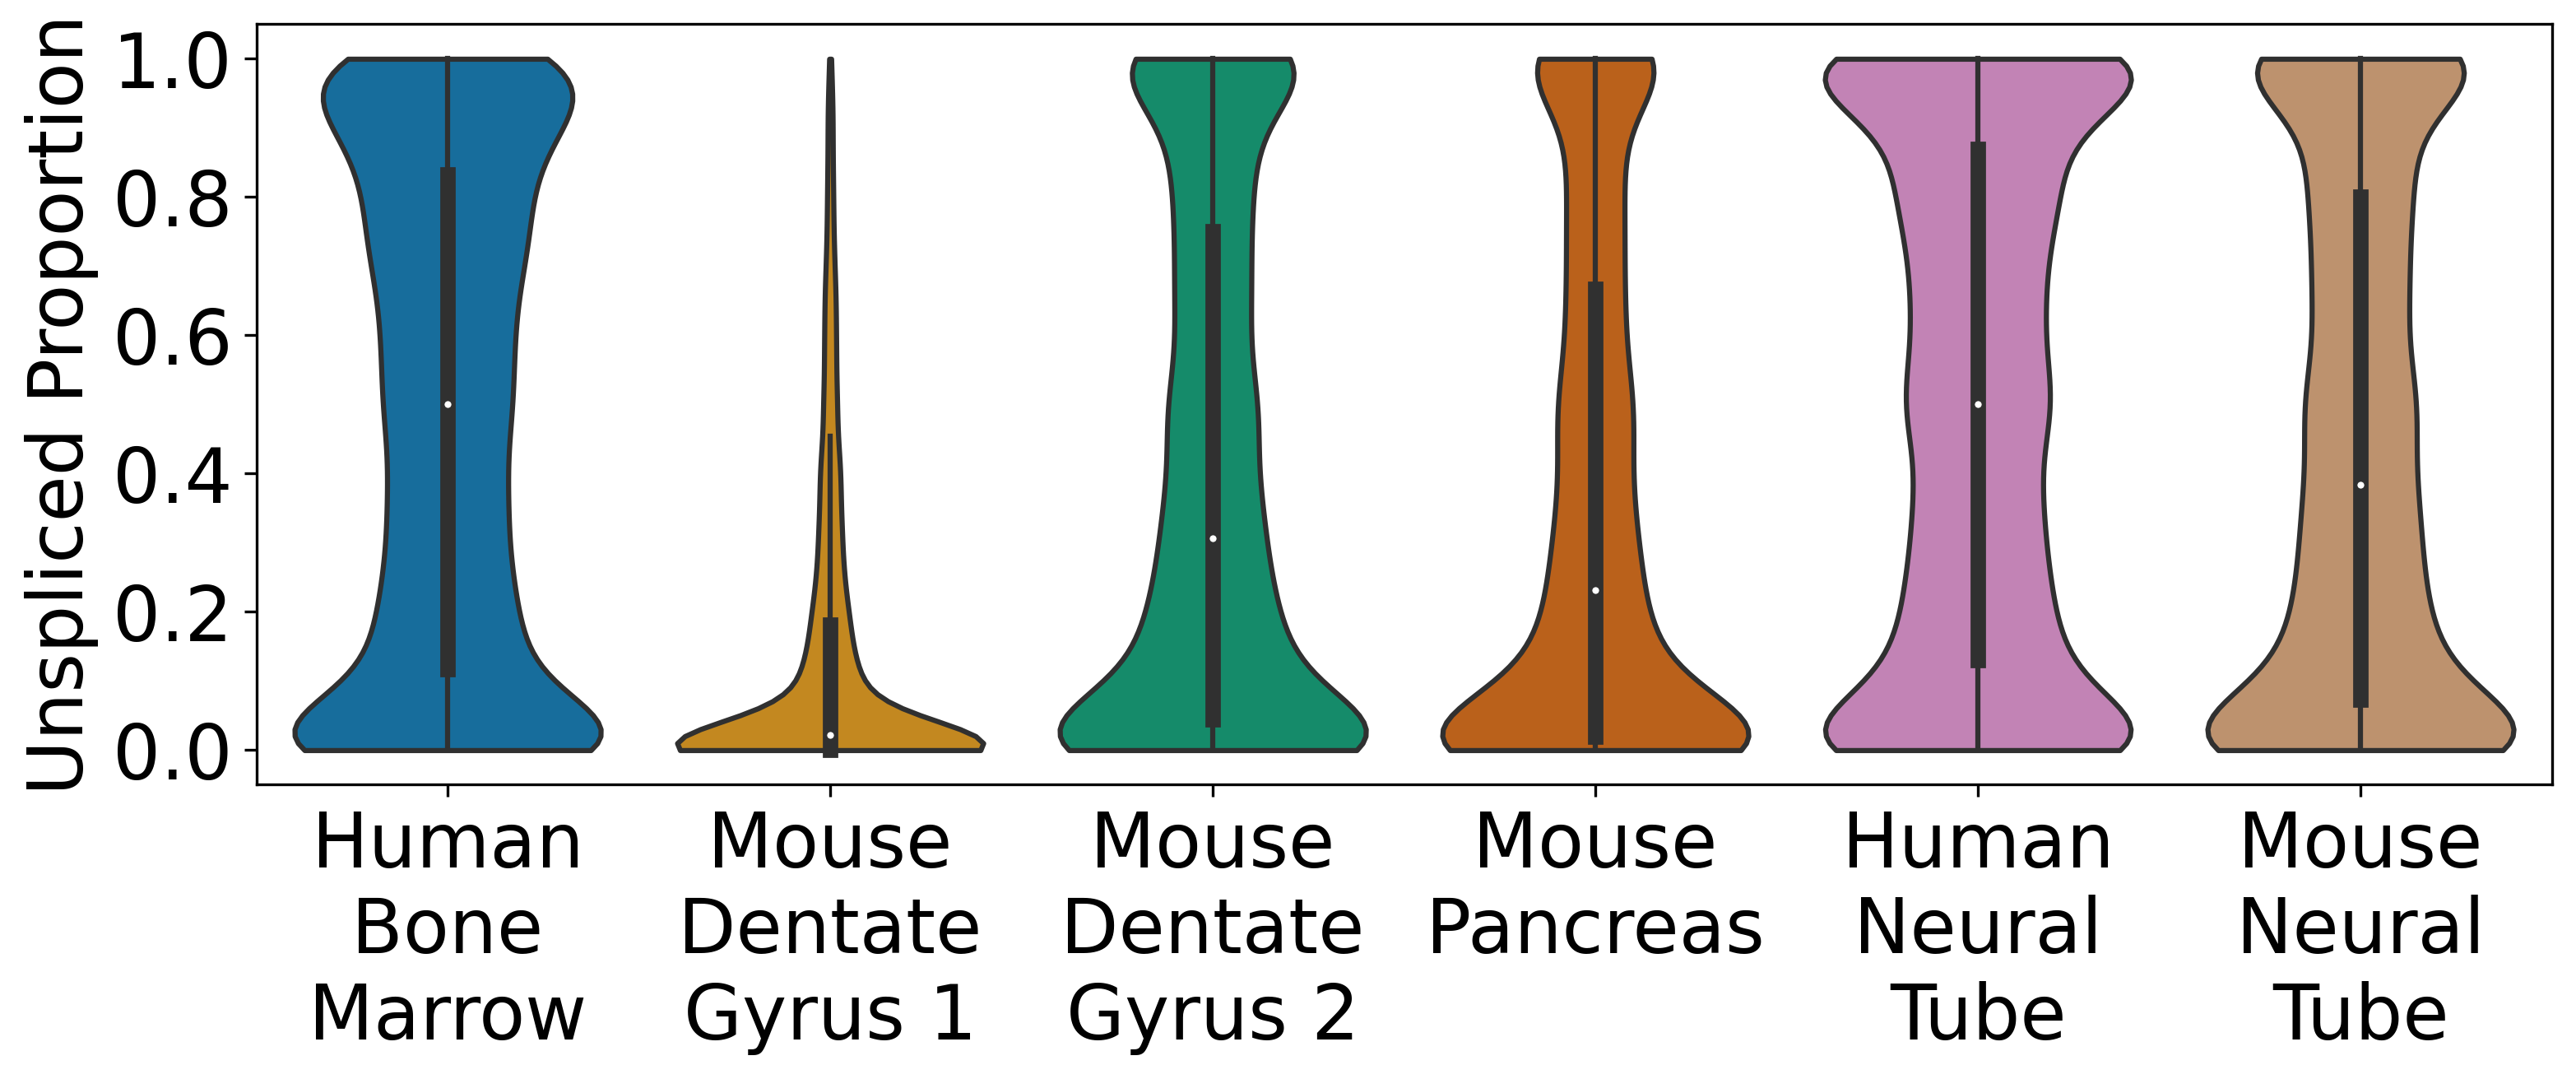

In [23]:
df2 = pd.DataFrame({'Dataset':dlist, 'Proportion':glist})

plt.figure(figsize=(12,4), dpi=300)
sns.violinplot(x='Dataset', y='Proportion', data=df2, cut=0, scale='width',palette=colpal.cmap_cat1)
plt.xticks(rotation=0, fontsize=22)
plt.yticks(rotation=0, fontsize=22)
plt.xlabel('', fontsize=22)
plt.ylabel('Unspliced Proportion', fontsize=22)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/0.4.1_across_datas_proportion.png', bbox_inches='tight')
plt.show()

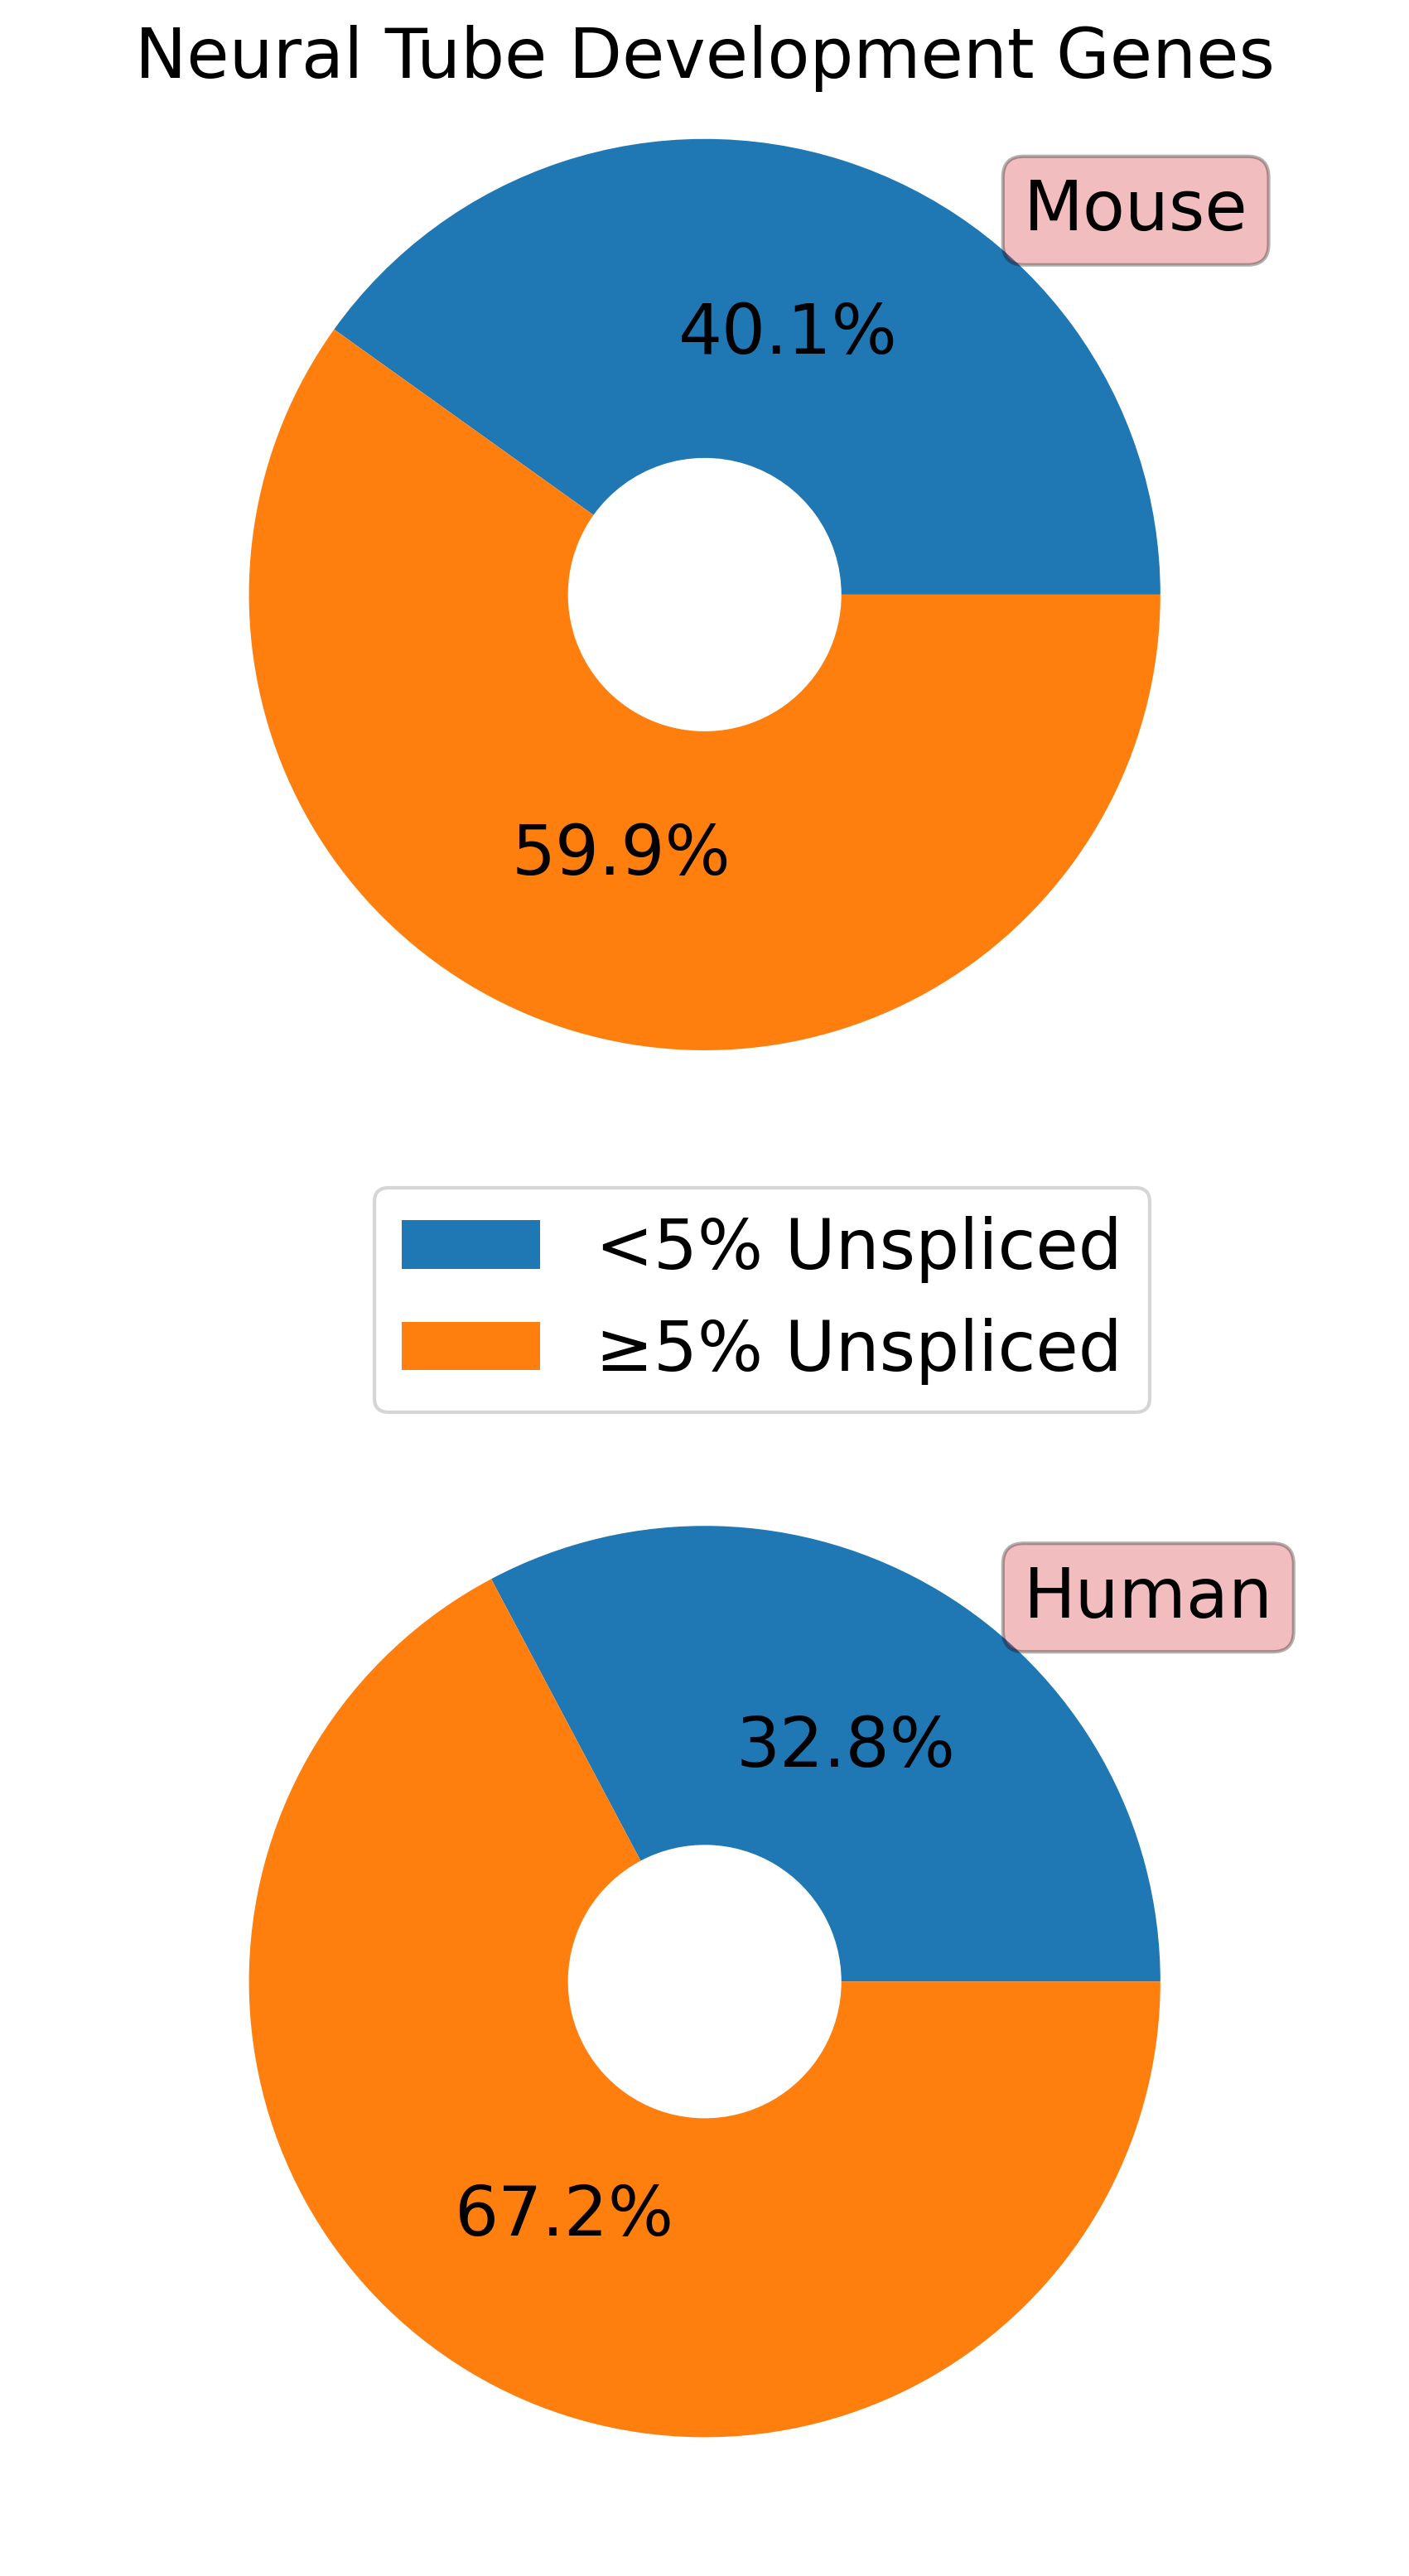

In [16]:
data1 = [nt_below5[0], 1 - nt_below5[0]]
data2 = [nt_below5[1], 1 - nt_below5[1]]
labs = ['<5% Unspliced', '≥5% Unspliced']

#create pie chart
plt.rcParams['font.size'] = 20

fig = plt.figure(figsize=(6,12), dpi=300)

ax1, ax2 = fig.subplots(2,1)
wedges, labels, autopct = ax1.pie(data1,labels=labs,
                                  autopct='%.1f%%', wedgeprops=dict(width=.7))
for lab in labels:
    lab.set_color('white')
    
wedges, labels, autopct = ax2.pie(data2,labels=labs, 
                                  autopct='%.1f%%', wedgeprops=dict(width=.7))
for lab in labels:
    lab.set_fontsize(1)
    lab.set_color('white')
plt.tight_layout()
ax2.legend(fontsize=20, loc=(.21,1))
plt.suptitle("Neural Tube Development Genes", y=0.9,fontsize=20)
props = dict(boxstyle='round', facecolor='tab:red', alpha=0.3)
ax1.text(0.7,0.8, 'Mouse', bbox=props, fontsize=20, rotation=0)
ax2.text(0.7,0.8, 'Human', bbox=props, fontsize=20, rotation=0)
plt.tight_layout()

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig("../figures/0.4.2_splicing_nt_genes.png", bbox_inches='tight')
plt.show()

# Pancreas demo

In [24]:
adata = scv.datasets.pancreas()
os.system("rm -r data")
adata

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [25]:
def directly_project_velocity(adata, X=None, V=None):
        if X==None:
            X = adata.layers['spliced']
        if V==None:
            V = adata.layers['velocity']

        X = np.array(X.A if issparse(X) else X)
        V = np.array(V.A if issparse(V) else V)
        Y = np.clip(X + V, 0, 1000)

        Xlog = np.log1p(X)
        Xlogscale = Xlog - Xlog.mean(0)
        pca = PCA()
        Xpca = pca.fit_transform(Xlogscale)
        adata.obsm['X_pca'] = Xpca

        Ylogscale = np.log1p(Y) - Xlog.mean(0)
        Ypca = pca.transform(Ylogscale)

        adata.obsm['velocity_pca'] = Ypca - Xpca
        adata.uns["velocity_params"] = {'embeddings':'pca'}

In [26]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

X = adata.layers['spliced']
X = np.array(X.A if issparse(X) else X)
Xlog = np.log1p(X)
Xlogscale = Xlog - Xlog.mean(0)
pca = PCA()
Xpca = pca.fit_transform(Xlogscale)
adata.obsm['X_pca'] = Xpca

scv.tl.velocity(adata)

direct = adata.copy()
neighs = adata.copy()
scv.pp.neighbors(neighs)
scv.tl.velocity_graph(neighs, n_jobs=1, )
scv.tl.velocity_embedding(neighs, basis='pca')
scv.tl.velocity_embedding(neighs, basis='umap') #umap is precomputed
directly_project_velocity(direct)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/80 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


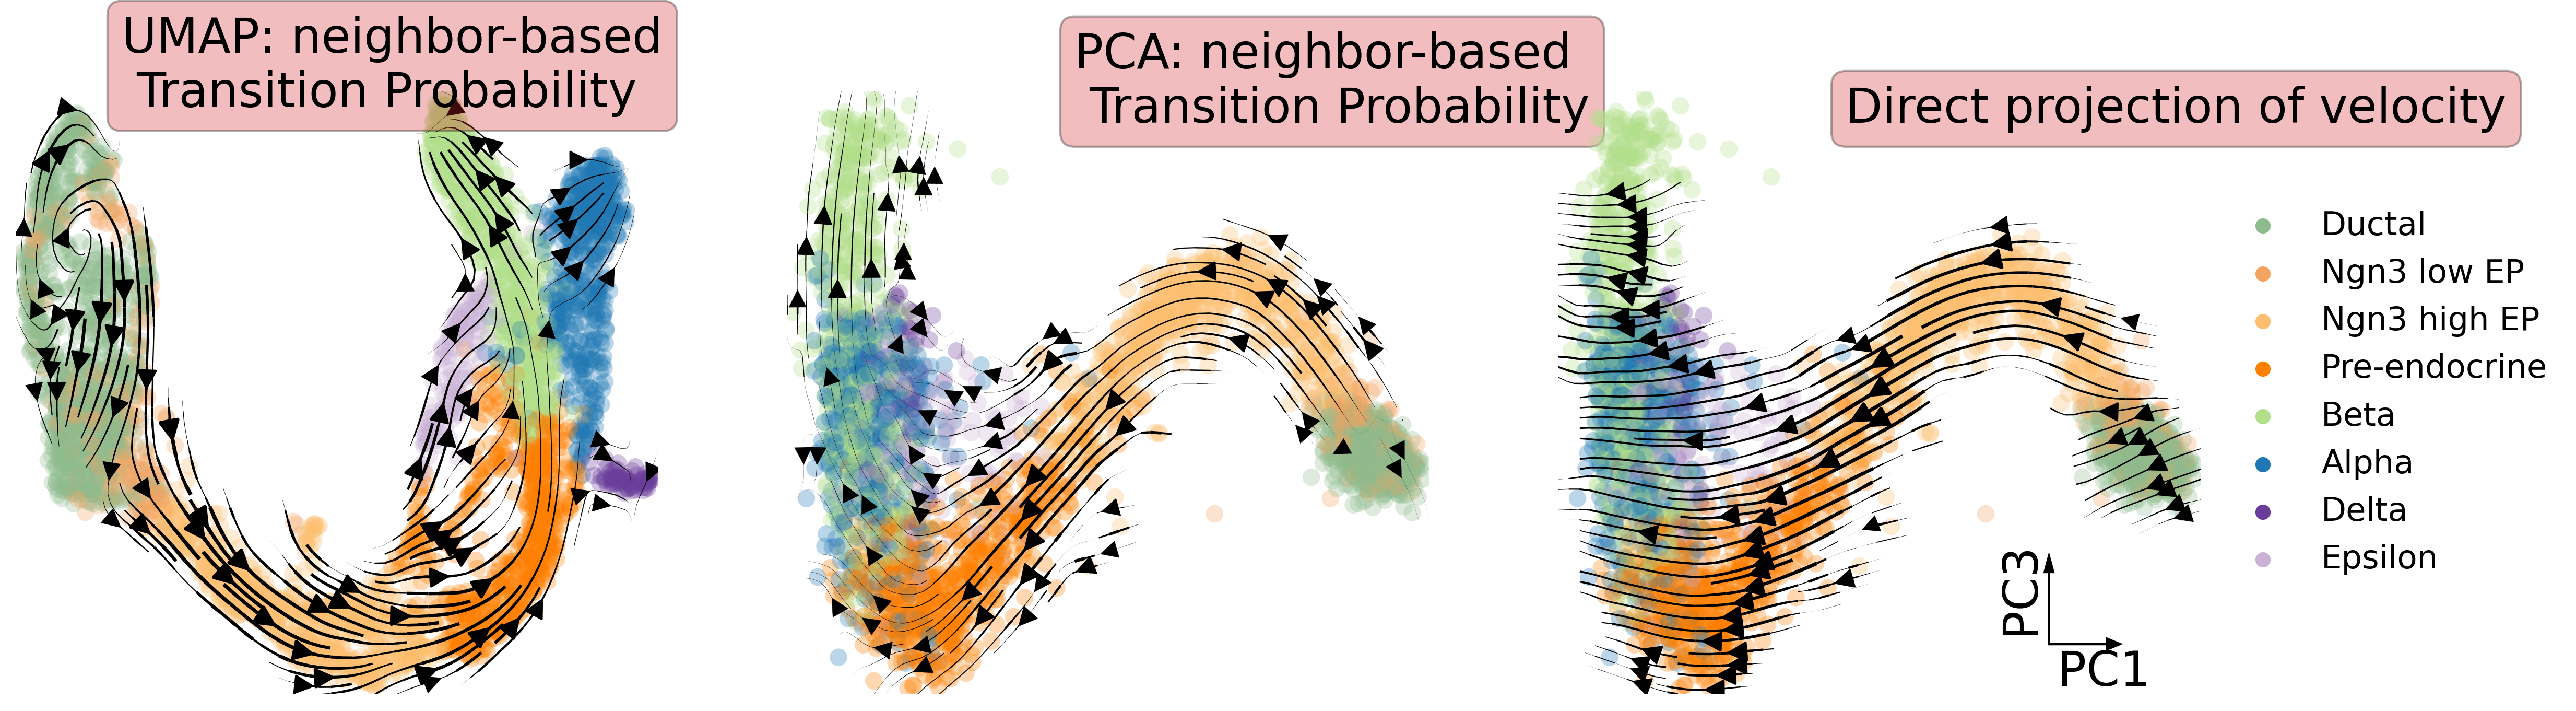

In [31]:
components="1,3" #this actually is more informative a visualisation than components 1 and 2, for this dataset
color='clusters'

fig = plt.figure(figsize=(18,5), dpi=300)
ax1, ax2, ax3 = fig.subplots(1,3)
scv.pl.velocity_embedding_stream(neighs, basis='umap', title='', fontsize=15, color=color, arrow_size=2,
                                 legend_loc=False, show=False, ax=ax1)
scv.pl.velocity_embedding_stream(neighs, basis='pca', title='', fontsize=15, color=color, arrow_size=2,
                                 legend_loc=False, show=False, ax=ax2, components=components)
scv.pl.velocity_embedding_stream(direct, basis='pca', title='', fontsize=15, color=color, arrow_size=2,
                                 legend_fontsize=15,
                                 legend_loc='right margin', show=False, ax=ax3, components=components)

props = dict(boxstyle='round', facecolor='tab:red', alpha=0.3)
ax1.text(-9,6.5, 'UMAP: neighbor-based\n Transition Probability', bbox=props, fontsize=22)
ax2.text(-1,8.5, 'PCA: neighbor-based\n Transition Probability', bbox=props, fontsize=22)
ax3.text(-1,8.5, 'Direct projection of velocity', bbox=props, fontsize=22)
plt.suptitle("", fontsize=22)
ax3.arrow(6,-6,2,0, width=0.01, head_width=.3, color='k')
ax3.arrow(6,-6,0,2, width=0.01, head_width=.3, color='k')
ax3.text(4.2,-5.45,'PC3', rotation=90, fontsize=22)
ax3.text(6.3,-7.15,'PC1', fontsize=22)
plt.savefig('../figures/0.4.3_scvelo_demo.png', bbox_inches='tight', transparent=True)
plt.show()